# Import libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from xgboost import DMatrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load Students' Dropout and Academic Success data

In [27]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/697/data.csv')
print("Dataset Head:")
print(df.head())

# Define features (X) and target (y)
X = df.drop(columns=['Target'])
y = df['Target']

# Split into 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)

Dataset Head:
   Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                       

# Segregate data

In [28]:
# Segregate the data base on its type
cat = [
    "Marital Status", 
    "Application mode", 
    "Course",
    "Previous qualification", 
    "Nacionality", 
    "Mother's qualification", 
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]

bin = [
    "Daytime/evening attendance",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

ord = [
    "Application order"
]

df_cat = df[cat + ['Target']]
df_bin = df[bin + ['Target']]
df_num = df.drop(columns=cat + bin)

# Preprocess data

In [29]:
# Encode variables
he = OneHotEncoder()
sc = StandardScaler()
le = LabelEncoder()

# Scale continuous variables
x_num = df.drop(columns=cat + bin + ['Target'])
x_num = sc.fit_transform(x_num)

# Segregate feature and label variables
x = x_num
y = df['Target'].to_numpy()

# Create training, validation, and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)

(3096, 19)
(1328, 19)


In [30]:
# Apply SMOTE to the training and validation data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Encode target labels into numeric values
y_train_res_encoded = le.fit_transform(y_train_res)
y_test_encoded = le.transform(y_test)

print(X_train.shape)
print(X_train_res.shape)
print(X_test.shape)

(3096, 19)
(4638, 19)
(1328, 19)


In [31]:
# Prepare data for dimension reduction
X_train_res_num = X_train_res[:, -len(x_num[0]):]
X_test_num = X_test[:, -len(x_num[0]):]

print(X_train_res_num.shape)
print(X_test_num.shape)

(4638, 19)
(1328, 19)


# KNN

## Perform dimension reduction to the data using LDA

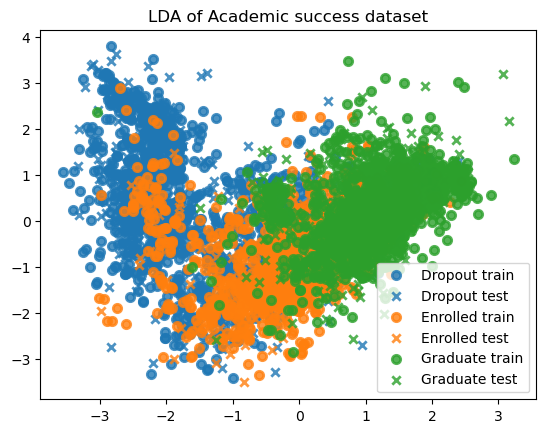

In [32]:
# Define colors and target names
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
target_name = np.unique(y_train_res)

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_res_num, y_train_res_encoded)
X_test_lda = lda.transform(X_test_num)

# LDA Results
for color, target_name in zip(colors, target_name):
    plt.scatter(X_train_lda[y_train_res == target_name, 0], X_train_lda[y_train_res == target_name, 1], 
                color=color, alpha=0.8, lw=2, label=f"{target_name} train")
    plt.scatter(X_test_lda[y_test == target_name, 0], X_test_lda[y_test == target_name, 1], 
                color=color, alpha=0.8, lw=2, label=f"{target_name} test", marker='x')
    
plt.legend(loc="best", shadow=False)
plt.title("LDA of Academic success dataset")
plt.show()

## Perform KNN


kNN for k = 1

Training Classification Report:
precision       1.0
recall          1.0
f1-score        1.0
support      4638.0
Name: weighted avg, dtype: float64

Training: Confusion Matrix
[[1546    0    0]
 [   0 1546    0]
 [   0    0 1546]]

Testing Classification Report:
precision       0.662894
recall          0.615211
f1-score        0.633245
support      1328.000000
Name: weighted avg, dtype: float64

Testing: Confusion Matrix
[[275 104  48]
 [ 64 103  71]
 [ 63 161 439]]

kNN for k = 3

Training Classification Report:
precision       0.801225
recall          0.800992
f1-score        0.800824
support      4638.000000
Name: weighted avg, dtype: float64

Training: Confusion Matrix
[[1293  175   78]
 [ 208 1168  170]
 [ 128  164 1254]]

Testing Classification Report:
precision       0.699670
recall          0.655873
f1-score        0.671411
support      1328.000000
Name: weighted avg, dtype: float64

Testing: Confusion Matrix
[[300  95  32]
 [ 64 116  58]
 [ 67 141 455]]

kNN for

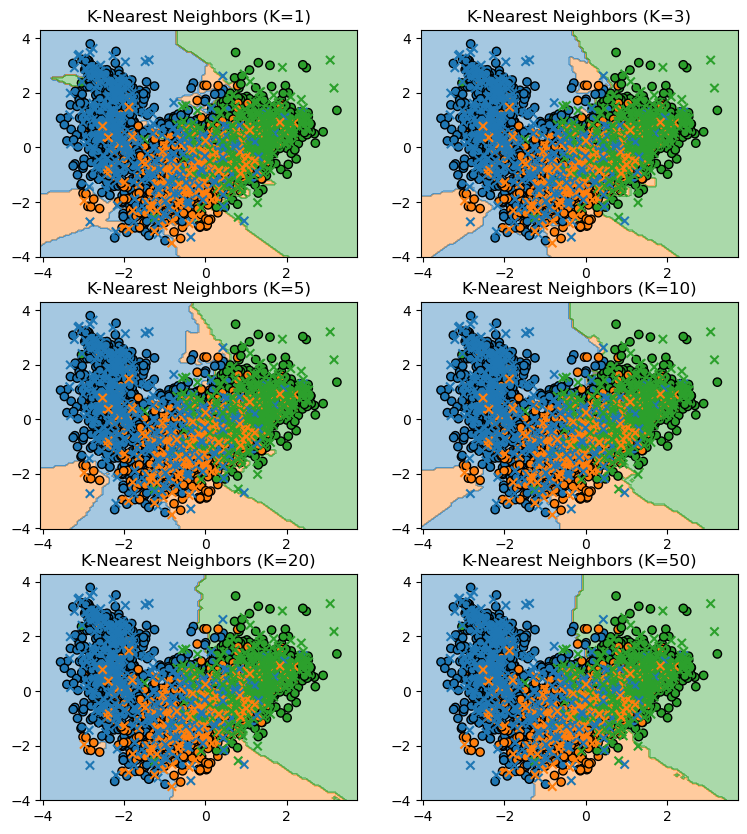

In [33]:
# Perform KNN classification
X_lda = np.vstack((X_train_lda,X_test_lda))

i = 1
figure = plt.figure(figsize=(9, 10))

for neigh in np.array([1, 3, 5, 10, 20, 50]):
    knn = KNeighborsClassifier(n_neighbors=neigh)
    knn.fit(X_train_lda, y_train_res_encoded)
    print(f"\nkNN for k = {neigh}")

    # Training weighted average accuracy
    tr_rep = classification_report(y_train_res_encoded, knn.predict(X_train_lda), target_names=np.unique(y_train_res), output_dict=True)
    tr_res = pd.DataFrame(tr_rep).T
    tr_weighted_avg = tr_res.loc['weighted avg']
    print("\nTraining Classification Report:")
    print(tr_weighted_avg)
    print('\nTraining: Confusion Matrix')
    print(confusion_matrix(y_train_res_encoded, knn.predict(X_train_lda)))
    
    # Testing weighted average report
    ts_rep = classification_report(y_test_encoded, knn.predict(X_test_lda), target_names=np.unique(y_train_res), output_dict=True)
    ts_res = pd.DataFrame(ts_rep).T
    ts_weighted_avg = ts_res.loc['weighted avg']
    print("\nTesting Classification Report:")
    print(ts_weighted_avg)
    print('\nTesting: Confusion Matrix')
    print(confusion_matrix(y_test_encoded, knn.predict(X_test_lda)))
    print("===========================================================")

    ax = plt.subplot(3, 2, i)
    cm = ListedColormap(colors)
    DecisionBoundaryDisplay.from_estimator(knn, X_lda, cmap=cm, ax=ax, alpha=0.4, eps=0.5)
    plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train_res_encoded, cmap=cm, edgecolors="k")
    plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=y_test_encoded, cmap=cm, marker='x')
    plt.title(f"K-Nearest Neighbors (K={neigh})")
    i += 1

plt.show()

# Random forest

## Perform random forest classifier

### Full dataset

In [34]:
# Perform random forest from full dataset
i = 1
figure = plt.figure(figsize=(9, 10))
for n_estimators in [1, 10, 20, 50, 100, 200]:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train_res, y_train_res_encoded)
    print(f"Random Forest number of estimators = {n_estimators}")

    # Training weighted average accuracy
    tr_rep = classification_report(y_train_res_encoded, rf.predict(X_train_res), target_names=np.unique(y_train_res), output_dict=True)
    tr_res = pd.DataFrame(tr_rep).T
    tr_weighted_avg = tr_res.loc['weighted avg']
    print("\nTraining Classification Report:")
    print(tr_weighted_avg)
    print('\nTraining: Confusion Matrix')
    print(confusion_matrix(y_train_res_encoded, rf.predict(X_train_res)))

    # Testing weighted average report
    ts_rep = classification_report(y_test_encoded, rf.predict(X_test), target_names=np.unique(y_train_res), output_dict=True)
    ts_res = pd.DataFrame(ts_rep).T
    ts_weighted_avg = ts_res.loc['weighted avg']
    print("\nTesting Classification Report:")
    print(ts_weighted_avg)
    print('\nTesting: Confusion Matrix')
    print(confusion_matrix(y_test_encoded, rf.predict(X_test)))
    print("===========================================================")

Random Forest number of estimators = 1

Training Classification Report:
precision       0.889423
recall          0.889176
f1-score        0.889239
support      4638.000000
Name: weighted avg, dtype: float64

Training: Confusion Matrix
[[1364  117   65]
 [  94 1370   82]
 [  62   94 1390]]

Testing Classification Report:
precision       0.670421
recall          0.649096
f1-score        0.658215
support      1328.000000
Name: weighted avg, dtype: float64

Testing: Confusion Matrix
[[278  99  50]
 [ 71  96  71]
 [ 71 104 488]]
Random Forest number of estimators = 10

Training Classification Report:
precision       0.992669
recall          0.992669
f1-score        0.992669
support      4638.000000
Name: weighted avg, dtype: float64

Training: Confusion Matrix
[[1532    3   11]
 [   7 1538    1]
 [   5    7 1534]]

Testing Classification Report:
precision       0.722087
recall          0.718373
f1-score        0.720095
support      1328.000000
Name: weighted avg, dtype: float64

Testing: Co

<Figure size 900x1000 with 0 Axes>

### Reduce dataset


Random Forest Classifier number of estimators = 1

Training Classification Report:
precision       0.854989
recall          0.854463
f1-score        0.854638
support      4638.000000
Name: weighted avg, dtype: float64

Training: Confusion Matrix
[[1330  147   69]
 [ 107 1298  141]
 [  71  140 1335]]

Testing Classification Report:
precision       0.672586
recall          0.615211
f1-score        0.635639
support      1328.000000
Name: weighted avg, dtype: float64

Testing: Confusion Matrix
[[283 112  32]
 [ 61 107  70]
 [ 70 166 427]]

Random Forest Classifier number of estimators = 10

Training Classification Report:
precision       0.978431
recall          0.978439
f1-score        0.978432
support      4638.000000
Name: weighted avg, dtype: float64

Training: Confusion Matrix
[[1520   12   14]
 [  29 1500   17]
 [   2   26 1518]]

Testing Classification Report:
precision       0.715733
recall          0.663404
f1-score        0.681802
support      1328.000000
Name: weighted avg, dty

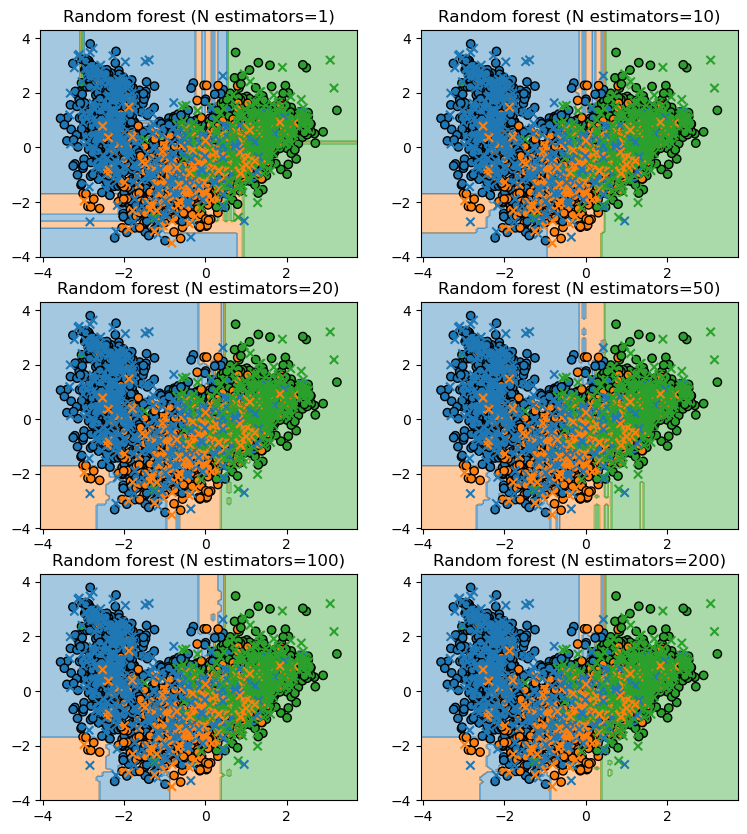

In [35]:
# Perform random forest from reduced data

i = 1
figure = plt.figure(figsize=(9, 10))
for n_estimators in [1, 10, 20, 50, 100, 200]:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train_lda, y_train_res_encoded)
    print(f"\nRandom Forest Classifier number of estimators = {n_estimators}")

    # Training weighted average accuracy
    tr_rep = classification_report(y_train_res_encoded, rf.predict(X_train_lda), target_names=np.unique(y_train_res), output_dict=True)
    tr_res = pd.DataFrame(tr_rep).T
    tr_weighted_avg = tr_res.loc['weighted avg']
    print("\nTraining Classification Report:")
    print(tr_weighted_avg)
    print('\nTraining: Confusion Matrix')
    print(confusion_matrix(y_train_res_encoded, rf.predict(X_train_lda)))
    
    # Testing weighted average report
    ts_rep = classification_report(y_test_encoded, rf.predict(X_test_lda), target_names=np.unique(y_train_res), output_dict=True)
    ts_res = pd.DataFrame(ts_rep).T
    ts_weighted_avg = ts_res.loc['weighted avg']
    print("\nTesting Classification Report:")
    print(ts_weighted_avg)
    print('\nTesting: Confusion Matrix')
    print(confusion_matrix(y_test_encoded, rf.predict(X_test_lda)))
    print("===========================================================")

    ax = plt.subplot(3, 2, i)
    cm = ListedColormap(colors)
    DecisionBoundaryDisplay.from_estimator(rf, X_lda, cmap=cm, ax=ax, alpha=0.4, eps=0.5)
    plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train_res_encoded, cmap=cm, edgecolors="k")
    plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=y_test_encoded, cmap=cm, marker='x')
    plt.title(f"Random forest (N estimators={n_estimators})")
    i += 1

plt.show()

# Boosted classification algorithm

## Perform boosted tree

### Full dataset

In [36]:
# Create classification matrices
dtrain_clf = DMatrix(X_train_res, label=y_train_res_encoded, enable_categorical=True)
dtest_clf = DMatrix(X_test, label=y_test_encoded, enable_categorical=True)

# Define parameters for XGBoost
params = {
    'objective':      'multi:softprob',
    'booster':        'gbtree',    
    'num_class':      3,           
    'seed':           42   
}

# Set number of rounds
num_round = 200

# Implement XGBoost
res = xgb.cv(
    params,
    dtrain_clf,
    num_boost_round=num_round,
    nfold=5,
    metrics='auc',
)

# Retain best round
best_round = res['test-auc-mean'].idxmax()
print(f"Best round: {best_round}")

# Train the model
bst = xgb.train(
    params,
    dtrain_clf,
    num_boost_round=best_round
)

# Predict probabilities, then choose highest‑prob class
y_prob = bst.predict(dtest_clf)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, digits=4, target_names=np.unique(y_train_res)))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

Best round: 175

Classification Report:
              precision    recall  f1-score   support

     Dropout     0.7629    0.6932    0.7264       427
    Enrolled     0.4091    0.3782    0.3930       238
    Graduate     0.8069    0.8763    0.8402       663

    accuracy                         0.7282      1328
   macro avg     0.6596    0.6492    0.6532      1328
weighted avg     0.7215    0.7282    0.7235      1328

Confusion Matrix:
[[296  71  60]
 [ 69  90  79]
 [ 23  59 581]]


### Reduce dataset

In [37]:
# Create classification matrices
dtrain_clf_red = DMatrix(X_train_lda, label=y_train_res_encoded, enable_categorical=False)
dtest_clf_red = DMatrix(X_test_lda, label=y_test_encoded, enable_categorical=False)

# Implement XGBoost CV with same hyperparameters and rounds
res_red = xgb.cv(
    params,
    dtrain_clf_red,
    num_boost_round=num_round,
    nfold=5,
    metrics='auc',
)

# Retain best round
best_round_red = res_red['test-auc-mean'].idxmax()
print(f"Best round (reduced): {best_round_red}")

# Train the model
bst_red = xgb.train(
    params,
    dtrain_clf_red,
    num_boost_round=best_round_red
)

# Predict probabilities, then choose highest‑prob class
y_prob = bst_red.predict(dtest_clf_red)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, digits=4, target_names=np.unique(y_train_res)))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

Best round (reduced): 7

Classification Report:
              precision    recall  f1-score   support

     Dropout     0.8445    0.6487    0.7338       427
    Enrolled     0.3698    0.6387    0.4684       238
    Graduate     0.8489    0.7541    0.7987       663

    accuracy                         0.6995      1328
   macro avg     0.6877    0.6805    0.6670      1328
weighted avg     0.7616    0.6995    0.7186      1328

Confusion Matrix:
[[277 117  33]
 [ 30 152  56]
 [ 21 142 500]]


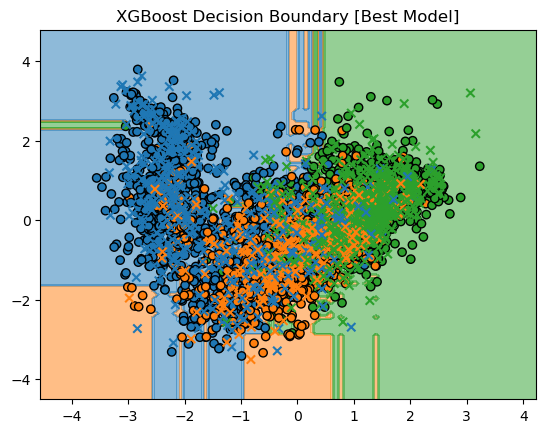

In [38]:
# Mapped xgb.train to xgb.XGBClassifier
mapped_params = {
    'objective':      'multi:softprob',
    'booster':        'gbtree',    
    'num_class':      3,           
    'seed':           42,
    'n_estimators':   num_round,
}
best_model_clf = xgb.XGBClassifier(**mapped_params)

# Fit the model to the training data
best_model_clf.fit(X_train_lda, y_train_res_encoded)

# Plot decision boundary
cm = ListedColormap(colors)
DecisionBoundaryDisplay.from_estimator(best_model_clf, X_lda, response_method="predict", cmap=cm, alpha=0.5)
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train_res_encoded, cmap=cm, edgecolors="k")
plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=y_test_encoded, cmap=cm, marker='x')
plt.title("XGBoost Decision Boundary [Best Model]")
plt.show()

# Conclusion

Given the imbalance label data, weighted average F1 score as a reference for comparison is ideal. With this, the model with the highest weighted average F1 score is the random forest with 100 estimators utilizing the full feature space (0.7291). This is followed by boosted tree algorithm with 175 estimators utilizing the full feature space (0.7235). The rest yielded a score between 0.70 to 0.71, indicating that there is not much signficant improvements. However, it is noted that the reduced feature space (2 components from LDA) is performing almost at par with the full feature space. In fact, the reduced feature space used in the boosting tree algorithm only needed 7 parameters, significantly reducing the effort to train models.